In [1]:
%matplotlib inline
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import seaborn as snb

from scipy.stats import poisson
from scipy.stats import gamma

from exercise9 import compute_effective_sample_size
from exercise9 import compute_Rhat
from exercise9 import plot_summary
from exercise9 import metropolis

# we want to use 64 bit floating precision
import jax
jax.config.update("jax_enable_x64", True)

# style stuff
snb.set_style('darkgrid')
snb.set_theme(font_scale=1.1)

# 02477 Bayesian Machine Learning - Exercise 9

### Overview

Markov Chain Monte Carlo (MCMC) techniques like Metropolis-Hastings and Gibbs sampling are very powerful methods in machine learning and statistics as they provide the computational tools for generating samples from complex distributions, e.g. posterior distributions of complex non-conjugate Bayesian models, but they are by no means limiting the Bayesian models.

The purpose of this exercise is to become familiar with Gibbs sampling as well as the Markov Chain Monte Carlo convergence diagnostics. First, we will study how to detect convergence in practice and how to compute the effective number of samples by taking the autocorrelation of the MCMC into account. Then, we will study Gibbs sampling using a simple Bayesian model for change point detection.


**Content**

- Part 1: The $\hat{R}$-statistic and the effective sample size
- Part 2: A simple model for change point detection in time series using Gibbs sampling
- Part 3: Implementing the Gibbs sampler
- Part 4: Visualizing the posterior distributions for the change point detection model



**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.

## Part 1:  The $\hat{R}$-statistic and the effective sample size

The purpose of the first part is to become familar with the MCMC convergence diagnostics denoted $\hat{R}$ as well as the effective sample size $S_\text{eff}$.  MCMC theory states that a well-designed MCMC algorithm converges asymptotically to the true target distribution, meaning that the Markov chain eventually will converge to the target distribution. The downside is that there is no strict theory for predicting when a chain will reach its stationary distribution, but there do exist heuristics that work very well in practice.


**Assessing convergence**

Intuitively, we can test convergence by running **multiple chains** in parallel starting from **different initial conditions**. After a given number of iterations, we can compare the chains. If the chains have reached stationarity, then they should all have the same stationary distribution independent of the initial condition. Therefore, if our chains do not have the same distributions, we can conclude the chains have not reached stationarity yet. In this case, we say that the chains have not **mixed**.

In practice, the so-called $\hat{R}$-statistic, also called the **potential scale reduction factor**, works well for assessing convergence:

$$\begin{align*}
\hat{R}^2 = \frac{S-1}{S} + \frac{1}{S}\frac{B}{W} \tag{1},
\end{align*}$$

where $S$ is the number of samples/iterations, $B$ is the **between-chain variance** and $W$ is the **within-chain variance**. If the between-chain variance is equal to the within-chain variance, then $\hat{R} = 1$, otherwise $\hat{R} > 1$. For most applications, the threshold $\hat{R} < 1.1$ works well for assesing convergence, but for more critical applications the threshold $\hat{R} < 1.01$ is recommended.

For more details, see Section 12.6.2.2. in Murphy2 or see p. 284 in Bayesian Data Analysis (http://www.stat.columbia.edu/~gelman/book/BDA3.pdf).

**Effective sample size**

Another very useful statistic in MCMC is the so-called **effective sample size (ESS)** defined by

$$\begin{align}
S_{\text{eff}}  = \frac{S}{\sum_{t=-\infty}^{\infty} \rho_t} = \frac{S}{1 + 2\sum_{t=1}^\infty \rho_t}\tag{2},
\end{align}$$


where $\rho_t$ is the autocorrelation of the chains at time lag $t$. Informally, a set of $S$ MCMC samples contains less information than $S$ independent samples from the same distribution due to the correlation between MCMC samples. The effective sample size helps us correct for this when computing the MCSE.

The provided functions `compute_Rhat` and `compute_effective_sample_size` compute $\hat{R}$ and $S_{\text{eff}}$, respectively. 

These diagnostics are evalauted after removing the **warmup** samples. And after we computed the diagnostics, we **merge** the samples from the individual chains into one long chain before using the samples for inference purposes.


**A bi-modal toy distribution**

To build intuition, we will first investigate these two statistics for a simple toy distribution, where we can easily compute the mean and variance reference:

$$\begin{align*}
p(x) = \frac12 \mathcal{N}(x| -3, 4) + \frac12 \mathcal{N}(x|1,2) \tag{3}
\end{align*}$$

Computing the first two moments yields (if you don't know how to do this, ask the teachers):


$$\begin{align*}
\mathbb{E}\left[x\right] &=  \frac12 \cdot (-3) + \frac12\cdot 1 = -1\\
\mathbb{E}\left[x^2\right] &=  \frac12 \cdot ((-3)^2 + 4) + \frac12\cdot (1^2 + 2) = 8,
\end{align*}$$

and hence, the variance of $p(x)$ is

$$\begin{align*}
\mathbb{V}\left[x\right] = \mathbb{E}\left[x^2\right] - \mathbb{E}\left[x\right]^2 = 8 - (-1)^2 = 7.
\end{align*}$$



Let's plot the density

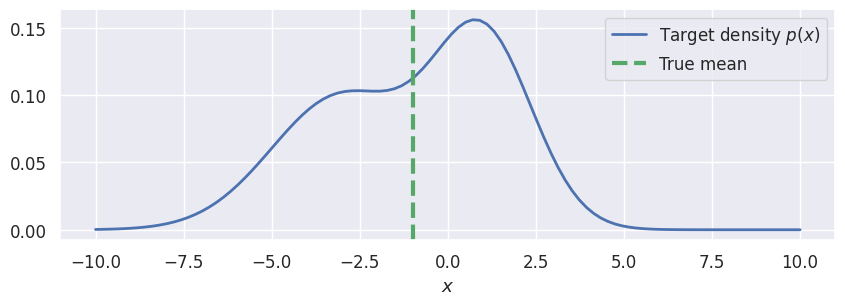

In [2]:
# define target
npdf = lambda x, m, v: jnp.exp(-(x-m)**2/(2*v))/jnp.sqrt(2*jnp.pi*v)
log_target = lambda x: jnp.log(0.5*npdf(x, -3, 4)  + 0.5*npdf(x, 1, 2))

# true mean and variance
true_mean = -1
true_var = 7

# plot
x_space = jnp.linspace(-10, 10, 100)[:, None]
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(x_space, jnp.exp(log_target(x_space)), label='Target density $p(x)$', linewidth=2)
ax.axvline(true_mean, color='g', linestyle='--', label='True mean', linewidth=3)
ax.legend()
ax.set_xlabel('$x$');

Next, we will implement a function that runs multiple MCMC chains using the Metropolis-Hastings algorithm from last week. You can either use your own implementation of the MH algorithm or you can use the one provided in `exercise9.metropolis`.

**Task 1.1**: Complete the implementation of the function `metropolis_multiple_chains` below such that it runs the Metropolis-Hastings sampler `num_chains` times. The function should return two arrays: 1) the samples for each chain and 2) the acceptance rate for each chain.



In [3]:
def metropolis_multiple_chains(log_target, num_params, num_chains, tau, num_iter, theta_init, seeds, warm_up=0):
    """ Runs multiple Metropolis-Hastings chains. The i'th chain should be initialized using the i'th vector in theta_init, i.e. theta_init[i, :]

    Arguments:
        log_target:         function for evaluating the log joint distribution
        num_params:         number of parameters of the joint distribution (integer)
        num_chains:         number of MCMC chains
        tau:                variance of Gaussian proposal distribution (positive real)
        num_iter:           number of iterations for each chain (integer)
        theta_init:         array of initial values (jnp.array with shape (num_chains, num_params))        
        seeds:              seed for each chain (jnp.array with shape (num_chains))
        warm_up:            number of warm up samples to be discarded
    
    returns:
        thetas              jnp.array of samples from each chain after warmup (shape: num_chains x (num_iter + 1 - warm_up))
        accept_rates        jnp.array of acceptances rate for each chain (shapes: num_chains)
    
     """
    
    # verify dimension of initial parameters 
    assert theta_init.shape == (num_chains, num_params), "theta_init seems to have the wrong dimensions. Plaese check your code."

    ##############################################
    # Your solution goes here
    ##############################################
    
    # prepare arrays for storing samples
    thetas = []
    accept_rates = []    

    # run sampler for each chain
    for idx_chain in range(num_chains):
        print(f'Running chain {idx_chain}. ', end='')
        thetas_temp, accepts_temp = metropolis(log_target, num_params, tau, num_iter, theta_init=theta_init[idx_chain], seed=seeds[idx_chain])
        thetas.append(thetas_temp)
        accept_rates.append(jnp.array(accepts_temp))

    thetas = jnp.stack(thetas, axis=0)
    accept_rates = jnp.stack(accept_rates, axis=0)

    # discard warm-up samples
    thetas = thetas[:, warm_up:, :]
    
    ##############################################
    # End of solution
    ##############################################

    # verify dimensions and return
    assert thetas.shape == (num_chains, num_iter+1-warm_up, num_params), f"The expected shape of chains is ({num_chains}, {num_iter+1-warm_up}, {num_params}) corresponding to (num_chains, num_iter+1-warm_up), but the actual shape is {thetas.shape}. Check your implementation."
    assert len(accept_rates) == num_chains
    return thetas, accept_rates

# mcmc settings
num_chains = 4
num_iter = 1000
proposal_variance = 0.1
num_params = 1
warm_up = 0
seeds = jnp.arange(num_chains)

# generate initial values from N(0, 5)
key = random.PRNGKey(1)
theta_init = 5*random.normal(key, shape=(num_chains, num_params))

# sample
chains, accepts = metropolis_multiple_chains(log_target, num_params, num_chains, proposal_variance, num_iter, theta_init, seeds, warm_up)

# report estimated mean and variance
print(f'\nEstimated mean:\t\t{jnp.mean(chains.ravel()):+3.2f}')
print(f'Estimated variance:\t{jnp.var(chains.ravel()):+3.2f}')

Running chain 0. Acceptance ratio: 0.99
Running chain 1. Acceptance ratio: 0.98
Running chain 2. Acceptance ratio: 0.99
Running chain 3. Acceptance ratio: 0.99

Estimated mean:		-0.94
Estimated variance:	+7.91


... and then let's plot and analyze the results

Estimated Rhat:				3.57
Total number of samples:		4000
Number of effective samples:		4
Relative sample efficiency:		0.001

The true mean is:			-1.00
The estimated mean is:			-0.94
The estimated variance is:		7.91
The MCSE for the mean is:		1.41


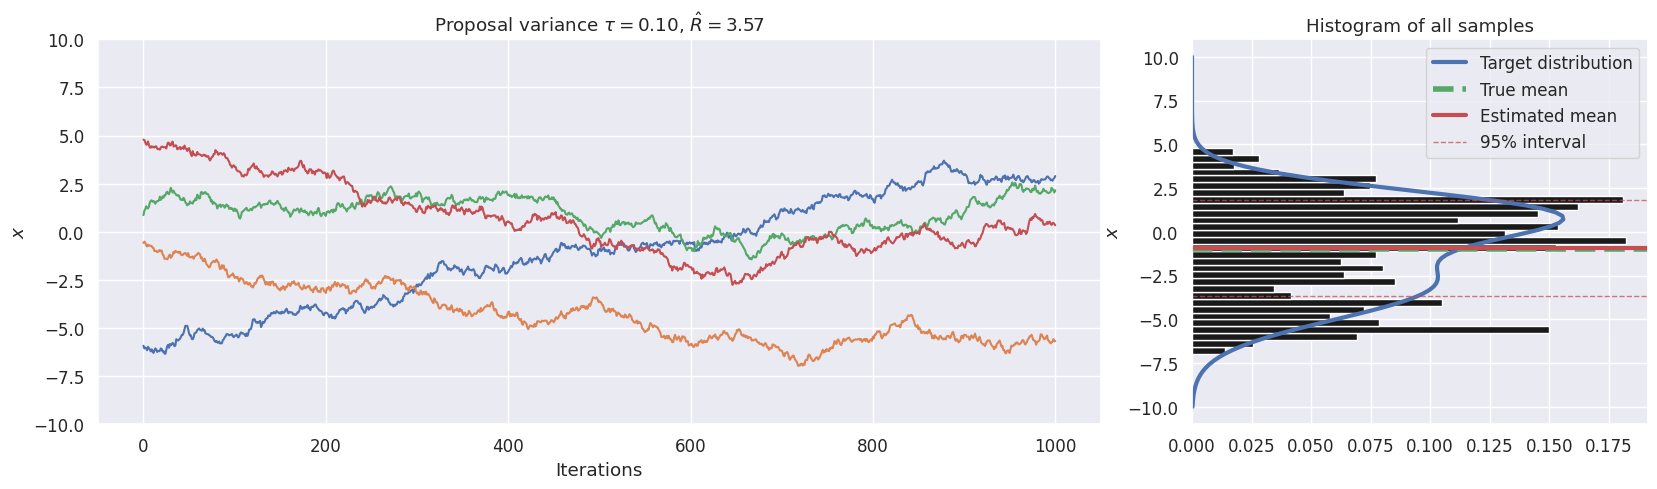

In [4]:
# compute estimate of mean and standard deviation
estimated_mean = jnp.mean(chains.ravel())
estimated_var = jnp.var(chains.ravel())
estimated_std = jnp.sqrt(estimated_var)

# compute \hat{R}-statistics (the function an array of shape (num_chains, num_samples, num_params))
Rhat = compute_Rhat(chains)

# calculate total number of samples across all chains, but excluding warm-up:
total_number_samples = num_chains * (num_iter - warm_up)

# calculate the number of effective samples (the function an array of shape (num_chains, num_samples, num_params))
S_eff = compute_effective_sample_size(chains)

# calculate relative sample efficiency
R_eff = S_eff/total_number_samples

# estimate MC error
MC_error = estimated_std/jnp.sqrt(S_eff)

# print results
print(f'Estimated Rhat:\t\t\t\t{Rhat[0]:3.2f}')
print(f'Total number of samples:\t\t{total_number_samples}')
print(f'Number of effective samples:\t\t{S_eff[0]}')
print(f'Relative sample efficiency:\t\t{R_eff[0]:4.3f}\n')


print(f'The true mean is:\t\t\t{true_mean:3.2f}')
print(f'The estimated mean is:\t\t\t{estimated_mean:3.2f}')
print(f'The estimated variance is:\t\t{estimated_var:3.2f}')
print(f'The MCSE for the mean is:\t\t{MC_error[0]:3.2f}')


# visualize
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
gs = axes[0].get_gridspec()
axes[0].remove()
axes[1].remove()
ax0 = fig.add_subplot(gs[:2])
ax1 = axes[2]
ax0.plot(chains[:, :, 0].T)
ax0.set(xlabel='Iterations', ylabel='$x$', ylim=(x_space[0,0], x_space[-1,0]), title=f'Proposal variance $\\tau = {proposal_variance:3.2f}$, $\\hat{{R}} =  {Rhat[0]:3.2f}$')

ax1.hist(chains.flatten(), 30, density=True, orientation='horizontal', color='k');
ax1.plot(jnp.exp(log_target(x_space)), x_space, linewidth=3, label='Target distribution');
ax1.axhline(true_mean, color='g', linestyle='--', linewidth=4, label='True mean')
ax1.axhline(estimated_mean, color='r', linestyle='-', linewidth=3, label='Estimated mean')
ax1.axhline(estimated_mean+1.96*MC_error, color='r', linestyle='--', linewidth=1, alpha=0.75)
ax1.axhline(estimated_mean-1.96*MC_error, color='r', linestyle='--', linewidth=1, label='95% interval', alpha=0.75)
ax1.set(ylabel='$x$', title='Histogram of all samples')
ax1.legend(loc='upper right');


The code above produces plots of the trace of the chain as well as the histogram of all the sample across all four chains. The plot also shows the estimated mean of the target distribution as well as a 95\% interval for the estimated based on the MCSE. (what is the difference between the interval and a 95\% interval for the target distribution?)

**Task 1.2**: Inspect the trace plot above. Based on a visual inspection, do the chains appear to have converged? Do the $\hat{R}$-statistic agree? How well does the histogram of the MCMC samples resemble the target density? [**Discussion question**]


**Task 1.3**: Experiment with the proposal variance - what happens to the $\hat{R}$-statistic and $S_{\text{eff}}$ when you increase $\tau$ to $\tau=0.5$? to $\tau=5$? to $\tau = 100$? [**Discussion question**]

**Task 1.4**: Explain the Monte Carlo Standard Error (MCSE) of the mean in your own words. Compare the MCSE with the difference between the estimated and true mean. [**Discussion question**]

**Task 1.5**: For how long do you need to run the chains to achieve a MCSE of $0.1$ or lower for $\tau=1$? What about $\tau=5$ or $\tau=100$?  [**Discussion question**]

**Task 1.6**: Compute and plot the relative sampling efficiency, i.e. effective number of samples divided by the total number of samples, as a function of the proposal variance in the interval from [$10^{-2}, 10^2]$. What is the optimal proposal variance for this toy distribution?  [**Discussion question**]

*Hint*: Use `np.logspace` to generate the values in the interval for the proposal variance.


**Solution**

Running MCMC with tau = 0.010 (1/20)
Running chain 0. Acceptance ratio: 1.00
Running chain 1. Acceptance ratio: 1.00
Running chain 2. Acceptance ratio: 1.00
Running chain 3. Acceptance ratio: 1.00
Running MCMC with tau = 0.016 (2/20)
Running chain 0. Acceptance ratio: 1.00
Running chain 1. Acceptance ratio: 1.00
Running chain 2. Acceptance ratio: 1.00
Running chain 3. Acceptance ratio: 1.00
Running MCMC with tau = 0.026 (3/20)
Running chain 0. Acceptance ratio: 1.00
Running chain 1. Acceptance ratio: 1.00
Running chain 2. Acceptance ratio: 1.00
Running chain 3. Acceptance ratio: 1.00
Running MCMC with tau = 0.043 (4/20)
Running chain 0. Acceptance ratio: 1.00
Running chain 1. Acceptance ratio: 1.00
Running chain 2. Acceptance ratio: 0.99
Running chain 3. Acceptance ratio: 1.00
Running MCMC with tau = 0.070 (5/20)
Running chain 0. Acceptance ratio: 0.99
Running chain 1. Acceptance ratio: 0.99
Running chain 2. Acceptance ratio: 0.99
Running chain 3. Acceptance ratio: 0.99
Running MCMC wi

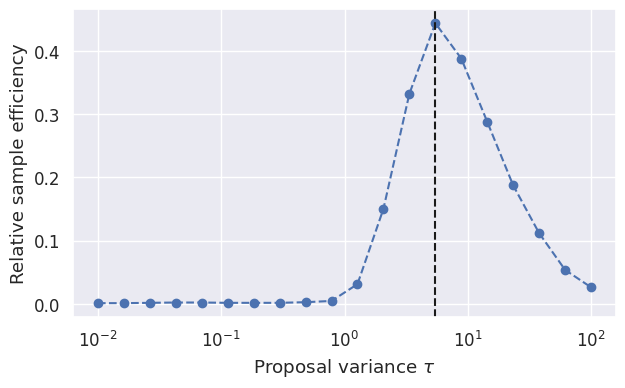

In [5]:
# sweep proposal variance
taus = jnp.logspace(-2, 2, 20)

# preallocate storage
R_effs = []
MCSEs = []

# MCMC settings
num_chains = 4
num_iter = 1000
num_params = 1
warmup = 500
seeds = jnp.arange(num_chains)
key = random.PRNGKey(123)
total_number_samples = num_chains * (num_iter - warmup)

theta_init = 5*random.normal(key, shape=(num_chains, num_params))


for idx_tau, tau in enumerate(taus):
    print(f'Running MCMC with tau = {tau:4.3f} ({idx_tau+1}/{len(taus)})')
    chains, accepts = metropolis_multiple_chains(log_target, num_params, num_chains, tau, num_iter, theta_init, seeds, warm_up)
    R_effs.append(compute_effective_sample_size(chains).ravel()/total_number_samples)

R_effs = jnp.array(R_effs).flatten()

idx_optimal = jnp.argmax(R_effs) 
print(f'Optimal proposal variance: {taus[idx_optimal]: 4.3f}')
print(f'Optimal relative sample efficiency: {R_effs[idx_optimal]: 4.3f}')

# plot results
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.semilogx(taus, R_effs, 'o--')
ax.set(xlabel='Proposal variance $\\tau$', ylabel='Relative sample efficiency')
ax.axvline(taus[idx_optimal], linestyle='--', color='k', label='Optimal tau');

**End of solution**

## Part 2:  A simple model for change point detection in time series using Gibbs sampling

In the part, we will consider a simple Bayesian model for change point detection in time series. Suppose we observe a sequence of observations $\mathcal{D} = \left\lbrace x_1, x_2, \ldots, x_N \right\rbrace$ and we assume that first part of the sequence, $x_1, \ldots, x_c$, is generated by one mechanism and the rest of the time series, $x_{c+1}, \ldots, x_N$, is generated by another mechanism for $1 \leq c \leq N$. The goal of change point detection is to estimate the unknown change point $c$, which is assumed to be an integer.

Such models are relevant in many applications, for example medical analysis (e.g. detection of sudden changes in biomedical signals), fault detection (e.g. $x_i$ could measure vibration in a wind turbine or other machinery), and fraud detection (e.g. monitoring the number of credit card transactions on websites).

In this exercise, we will use change point detection to analyze the number accidents in British coal mines from 1850 to 1965. Let's load and visualize the data:

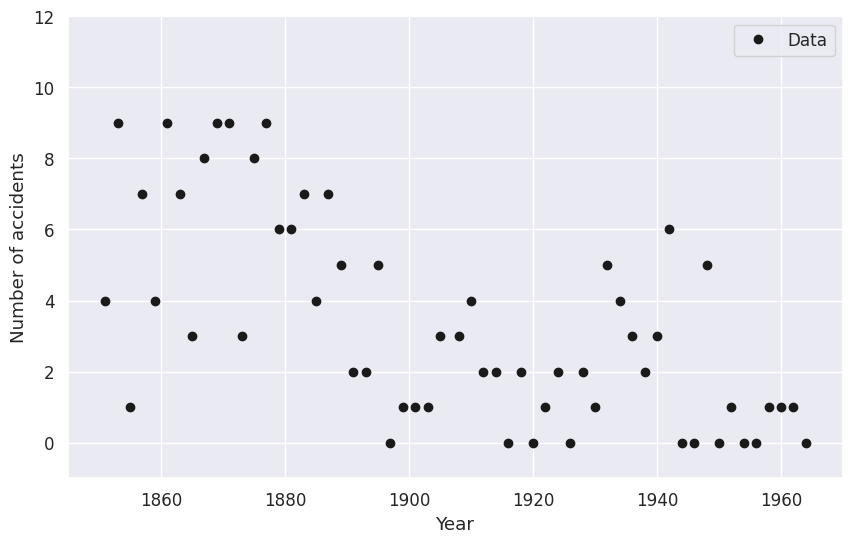

In [6]:
# load data
data = jnp.load('./coal_mine_data.npz')
accident_counts = data['accident_counts']
year = jnp.array(data['year'])
N = len(year)

# plot
def plot_data(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(year, accident_counts, 'ko', label='Data')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of accidents')
    ax.legend()
    ax.set_xlim((1845, 1970))
    ax.set_ylim((-1, 12))

plot_data()

The data set consists of $N = 57$ observations, where $x_1$ denotes the number of accidents from 1850 to 1852, $x_2$ denotes the number of accidents from 1852 to 1854 etc. Thus, all observations $x_n$ are non-negative integers. For each observation, $t_n$ denotes the time (in years) for the observation $x_n$.
Let's state the model
$$\begin{align*}
c &\sim \mathcal{U}\left[1, N\right]\\
\lambda_1 &\sim \text{Gamma}(\alpha, \beta)\\
\lambda_2 &\sim \text{Gamma}(\alpha, \beta)\\
x_i|\lambda_1, \lambda_2, c &\sim \begin{cases}\text{Poisson}(\lambda_1) & \text{if}\quad 1 \leq i \leq c\\ \text{Poisson}(\lambda_2) & \text{if}\quad c < i \leq N \end{cases} 
\end{align*}$$
where $\mathcal{U}\left[1, N\right]$ represents a uniform distribution over the integers from $1$ to $N$.

That is, we assume that measurements from **before** the change point, $c$, come from a Poisson distribution with parameter $\lambda_1$ and that measurements **after** the change point come from a Poisson distribution with parameter $\lambda_2$. 


**Task 2.1**: Why is the Poisson distribution a natural likelihood for this dataset? (in contrast to e.g. the Gaussian or the Binomial distribution) 

**Solution**

The observations are count data, and therefore, the Poisson distribution is a natural choice as it is a distribution over non-negative integers and the sample space is unbounded. In contrast, the Gaussian distribution has support on the entire real line (both positive and negative) and it is therefore not a suitable choice. The Binomial distribution is a distribution over a bounded interval of integers, i.e. it represents the outcome of a sequence $N$ of i.i.d. Bernoulli trials, where $N$ needs to be known in advance, and therefore, this distribution is not suitable either.

**End of solution**


The model has three parameters: $\lambda_1, \lambda_2, $ and $c$. In order to complete the Bayesian model, we need to specify priors for all parameters. We use Gamma distributions as priors for $\lambda_1$ and $\lambda_2$ because the Gamma distribution is conjugate to the Poisson distribution. For the unknown change point $c$, we impose a uniform prior over the integers from $1$ to $N = 57$ such that $p(c) = \frac{1}{57}$ for all $c$. In this exercise, we will use fixed values for $\alpha, \beta$ to $\alpha=1$ and $\beta=1$.

As usual, the posterior of interest is given by Bayes' theorem

\begin{align*}
p(\lambda_1, \lambda_2, c|\mathcal{D}) = \frac{p(x_{1:N},\lambda_1, \lambda_2, c)}{p(\mathcal{D})} =
\frac{p(x_{1:c}|\lambda_1)p(x_{{c+1}:N}|\lambda_2)p(\lambda_1)p(\lambda_2)p(c)}{p(\mathcal{D})} \propto p(x_{1:c}|\lambda_1)p(x_{{c+1}:N}|\lambda_2)p(\lambda_1)p(\lambda_2)p(c),
\end{align*}

where 

\begin{align*}
p(x_{1:c}|\lambda_1) &= \prod_{n=1}^c \text{Poisson}(x_n|\lambda_1)\\
p(x_{c+1:N}|\lambda_2) &= \prod_{n=c+1}^N \text{Poisson}(x_n|\lambda_2).
\end{align*}


Recall, the Poisson and Gamma distributions are given by

\begin{align*}
\text{Poisson}(k|\lambda) &= \frac{\lambda^k \exp(-\lambda)}{k!}\\
\text{Gamma}(\lambda|\alpha, \beta) &= \frac{1}{\Gamma(\alpha)} \beta^\alpha \lambda^{\alpha-1} \exp(-\beta\lambda),
\end{align*}

where the mean of Gamma distribution is $\mathbb{E}\left[\lambda\right] = \alpha\beta$ and the mean of a Poisson distribution is $\mathbb{E}\left[k\right] = \lambda$. 

**Note**: There are several ways to parametrize Gamma distributions, see e.g. [Gamma-distribution](https://en.wikipedia.org/wiki/Gamma_distribution). So if you are relying on software packages for computing quantities based on Gamma distributions, make sure to check which parametrization the software is expecting.

Despite the Gamma distribution being conjugate to the Poisson distribution, we cannot compute the posterior in closed-form because the model contains both $\lambda_1$ and $\lambda_2$ as well as the change point $c$. Instead, we will derive a Gibbs sampler for sampling-based inference.

**Task 2.2**: Identify the functional form for the Poisson distribution. That is, write the logarithm of the PMF and absorb all terms that are independent of $k$ into a constant.

**Solution**

\begin{align*}
\log \text{Poisson}(k|\lambda) &= \log  \frac{\lambda^k \exp(-\lambda)}{k!}\\
&= k \log (\lambda) - \lambda - \log (k!)\\
&=  k \log (\lambda) - \log (k!)  + K_p, 
\end{align*}

where $K_p$ contains the term indepedent of $k$. We say the $k \log (\lambda)  - \log (k!)$ is the **functional form** of the Poisson distribution. This is very useful, because we know that distributions have to be normalized, which means that if encounter a distribution of the same functional form, then we know it **must** be a Poisson distribution. We will see a concrete example soon.


**End of solution**

**Task 2.3**: Identify the functional form for the Gamma distribution.

**Solution**

\begin{align*}
\log \text{Gamma}(\lambda|\alpha, \beta) &= \frac{1}{\Gamma(\alpha)} \beta^\alpha \lambda^{\alpha-1} \exp(-\beta\lambda)\\
&= -\log(\Gamma(\alpha)) + \alpha \log(\beta) + (\alpha-1)\log(\lambda)-\beta\lambda\\  
&= (\alpha-1)\log(\lambda)-\beta\lambda + K_g,    \tag{5}
\end{align*}

where $K_g$ has absorbed all terms indepedent of $\lambda$. Therefore, the **functional form** of a Gamma distribution is $(\alpha-1)\log(\lambda)-\beta\lambda$.

**End of solution**



# Deriving the Gibbs sampler

Next, we will derive a Gibbs sampler for the simple change point model above. Recall, that the Gibbs sampler works by iteratively generating samples from each of the three posterior conditional distributions, i.e. $p(\lambda_1|x_{1:N}, \lambda_2, c)$, $p(\lambda_2|x_{1:N}, \lambda_1, c)$, and $p(c|x_{1:N}, \lambda_1, \lambda_2)$.


Now we're ready to derive the Gibbs sampler. Let's write out the log joint distribution of the model

\begin{align*}
\log p(x_{1:N},\lambda_1, \lambda_2, c) = \sum_{i=1}^c\log p(x_i|\lambda_1) + \sum_{i=c+1}^N\log p(x_{i}|\lambda_2) + \log p(\lambda_1) + \log p(\lambda_2) + \log p(c)
\end{align*}


Let's substitute in the expressions for the Poisson and Gamma distributions

\begin{align*}
\log p(x_{1:N},\lambda_1, \lambda_2, c) = &\sum_{i=1}^c \left[x_i \log (\lambda_1)  -\lambda_1 - \log (x_i!)\right] + \sum_{i=c+1}^N \left[x_i \log (\lambda_2)  -\lambda_2 - \log (x_i!)\right] \\
& -\log(\Gamma(\alpha)) + \alpha \log(\beta) + (\alpha-1)\log(\lambda_1)-\beta\lambda_1  -\log(\Gamma(\alpha)) + \alpha \log(\beta) + (\alpha-1)\log(\lambda_2)-\beta\lambda_2 + \log \frac{1}{N} \tag{6}
\end{align*}


**Task 2.4**: Show the posterior conditional distribution for $\lambda_1$ is given by $p(\lambda_1|x_{1:N}, \lambda_2, c) = \text{Gamma}(\lambda_1|\alpha + \sum_{i=1}^c x_i, \beta + c)$ 

*Hints*:

- *Start by writing up all the terms in eq. (6) that depends on $\lambda_1$.*

- *Collect all the terms that contains $\log(\lambda_1)$ and collect all the terms that contains $\lambda_1$.*

- *Compare the result to the functional form of a Gamma distribution.*


**Solution**

We will derive $p(\lambda_1|x_{1:N}, \lambda_2, c)$ by first collecting all the terms  in eq. (6) above that depend on $\lambda_1$. We have

\begin{align*}
\log p(\lambda_1|x_{1:N}, \lambda_2, c) &= \sum_{i=1}^c \left[ x_i \log (\lambda_1)  -\lambda_1 \right]+ (\alpha-1)\log(\lambda_1)-\beta\lambda_1 + K_1\\
&=\log (\lambda_1) \sum_{i=1}^c x_i   -c\lambda_1 + (\alpha-1)\log(\lambda_1)-\beta\lambda_1 + K_1\\
&= \left[\alpha + \sum_{i=1}^c x_i - 1\right] \log (\lambda_1)   -(\beta + c)\lambda_1 + K_1, \tag{7}
\end{align*}
where all the terms that do not depend on $\lambda_1$ have been absorbed into the constant $K_1$ (constant wrt. $\lambda_1$).

Eq. (7) now reveals that the function form of $p(\lambda_1|x_{1:N}, \lambda_2, c)$ is the same as for the Gamma distribution. By comparing the coefficients for $\log (\lambda_1)$ and $\lambda_1$, we conclude

\begin{align*}
    p(\lambda_1|x_{1:N}, \lambda_2, c) = \text{Gamma}(\lambda_1|\alpha + \sum_{i=1}^c x_i, \beta + c).
\end{align*}

The fact that this distribution turned out to be a Gamma distribution is a consequence of the Gamma distribution being conjugate to the Poisson distribution.


**End of solution**

**Task 2.5**: Derive the posterior conditional distribution for $p(\lambda_2|x_{1:N}, \lambda_1, c)$


**Solution**


Again, we will collect all the terms  in the eq. (6)  that depends on $\lambda_2$

\begin{align*}
    \log p(\lambda_2|x_{1:N}, \lambda_1, c) &=  \sum_{i=c+1}^N \left[x_i \log (\lambda_2)  -\lambda_2\right]  + (\alpha-1)\log(\lambda_2)-\beta\lambda_2 + K_2\\
    &=   \left[\alpha + \sum_{i=c+1}^N x_i -1\right]\log(\lambda_2) -(\beta + N-c)\lambda_2 + K_2 \tag{8}.
\end{align*}

By comparing eq. (8) to the functional form of a Gamma distribution, we again recognize the functional form of a Gamma distribution and conclude that 

\begin{align*}
    p(\lambda_2|x_{1:N}, \lambda_1, c) = \text{Gamma}(\lambda_2 |  \alpha + \sum_{i=c+1}^N x_i, \beta + N-c).
\end{align*}

**End of solution**

**Deriving the posterior conditional distribution for $p(c|x_{1:N}, \lambda_1, \lambda_2)$**

Finally, the last piece we need to run the Gibbs samler is $p(c|x_{1:N}, \lambda_1, \lambda_2)$. Again, we follow the same recipe and collect all the terms in the eq. (6)  that depends on $c$

\begin{align}
\log p(c|x_{1:N}, \lambda_1, \lambda_2) &=  \sum_{i=1}^c \left[x_i \log (\lambda_1)  -\lambda_1 - \log (x_i!)\right] + \sum_{i=c+1}^N \left[x_i \log (\lambda_2)  -\lambda_2 - \log (x_i!)\right] + K_3\\
&=   \log (\lambda_1) \sum_{i=1}^c x_i +   \log (\lambda_2) \sum_{i=c+1}^N x_i  -c\lambda_1 - \sum_{i=1}^c \log (x_i!)   -(N-c)\lambda_2 - \sum_{i=c+1}^N \log (x_i!) + K_3 \\
&=   \log (\lambda_1) \sum_{i=1}^c x_i +   \log (\lambda_2) \sum_{i=c+1}^N x_i  -c\lambda_1 - \sum_{i=1}^c \log (x_i!)- \sum_{i=c+1}^N \log (x_i!)    -(N-c)\lambda_2 + K_3 \\
&=   \log (\lambda_1) \sum_{i=1}^c x_i +   \log (\lambda_2) \sum_{i=c+1}^N x_i  -c\lambda_1 - \sum_{i=1}^N \log (x_i!)   -(N-c)\lambda_2 + K_3 \\
&=   \log (\lambda_1) \sum_{i=1}^c x_i +   \log (\lambda_2) \sum_{i=c+1}^N x_i  -c\lambda_1    -(N-c)\lambda_2 + K'_3 \tag{9}
\end{align}

This result is not recognized as any named distribution, but that is not a problem, because recall $c \in \left\lbrace 1, 2, \dots, 57\right\rbrace$, and hence, we can obtain the full distribution $p(c|x_{1:N}, \lambda_1, \lambda_2)$ by evaluting eq. (9) for all $N = 57$ values.


# Part 3:  Implementing the Gibbs sampler

**Task 3.1**: Complete the implementation of the `cpd_gibbs_sampler` below.

*Hints*: 
- *The functions `random.gamma` and `random.choice` will be handy.*
- *You can generate a sample from a Gamma(a,b)-distribution using JaX as `b*random.gamma(key, a)`*
- *When computing the probabilities for the posterior conditional of $c$, make sure to perform all computations in the logarithm-domains before exponentiating and normalizing the values into probabilities.*
- *The code below prepares three JaX keys (`key1`, `key2`, and `key3`) every iteration, which can be used for generating random numbers*

In [7]:

def cpd_gibbs_sampler(x, alpha, beta, num_iter, c_init, lambda1_init, lambda2_init, warmup=0, seed=0):
    """ 
        Implements a Gibbs sampler for the change point dection model.

        Arguments:
        x                    --          array of observations, expected to be a numpy array of shape (N)
        alpha                --          hyperparameter for the gamma distributions, positive real number
        beta                 --          hyperparameter for the gamma distributions, positive real number
        num_iter             --          number of iterations to run
        c_init               --          initial value for the parameter c, expected to be an integer between 1 and N
        lambda1_init         --          initial value for lambda1, expected to be a positive real number
        lambda2_init         --          initial value for lambda2, expected to be a positive real number
        warmup               --          number of MCMC iterations to be discarded as warm up, non-negative integer.
        seed                 --          integer

        Returns:
        lambda1_samples      --          jnp.array of posterior samples for lambda1, shape: (N - warmup + 1)
        lambda2_samples      --          jnp.array of posterior samples for lambda2, shape: (N - warmup + 1)
        c_samples            --          jnp.array of posterior samples for c, shape: (N - warmup + 1)
    """

    # num data points
    N = len(x)

    # prepare arrays for store the samples
    lambda1_samples = [lambda1_init]
    lambda2_samples = [lambda2_init]
    c_samples = [c_init]

    # initial key
    key = random.PRNGKey(seed)

    # iterate
    for k in range(num_iter):

        # update key
        key, subkey = random.split(key)
        key1, key2, key3 = random.split(subkey, num=3)

        ##############################################
        # Your solution goes here
        ##############################################
        
        
        # sample lambda 1
        c_k = int(c_samples[k])
        a = alpha + jnp.sum(x[:c_k])
        b = 1./(beta + c_k)
        lambda1_samples.append(b*random.gamma(key1, a))

        # sample lambda 2
        a = alpha + jnp.sum(x[c_k:])
        b = 1/(beta + N - c_k)
        lambda2_samples.append(b*random.gamma(key2, a))

        # sample c
        # compute log probabilities for all values of c
        log_prob_c = []
        for ci in range(N):
            log_prob_c.append(jnp.sum(x[:ci])*jnp.log(lambda1_samples[k+1]) - ci*lambda1_samples[k+1] + jnp.sum(x[ci:])*jnp.log(lambda2_samples[k+1]) - (N-ci)*lambda2_samples[k+1])

        # ... and normalize
        log_prob_c = jnp.array(log_prob_c)
        log_prob_c = log_prob_c - jnp.max(log_prob_c)
        prob_c = jnp.exp(log_prob_c)
        prob_c = prob_c/jnp.sum(prob_c)

        # finally sample new c
        c_samples.append(random.choice(key3, jnp.arange(N), p=prob_c))
        
        ##############################################
        # End of solution
        ##############################################

        if (k+1) % (num_iter/5) == 0:
            print(f'Itt {k+1}/{num_iter}')

                
    # discard warmup samples?    
    if warmup:
        lambda1_samples = lambda1_samples[warmup:]
        lambda2_samples = lambda2_samples[warmup:]
        c_samples = c_samples[warmup:]

    return jnp.array(lambda1_samples), jnp.array(lambda2_samples), jnp.array(c_samples)

**Task 3.2**: Fix $\alpha = 1$ and $\beta=1$ and run 4 chains for 2000 iterations with 50% warmup. Initialize the MCMC chains using a uniform distribution for $c$, i.e. $c \sim \mathcal{U}\left[1, 2, \dots, N\right]$ and $\lambda_1, \lambda_2 \sim \text{Gamma}(\alpha, \beta)$.

*Hint: Remember to use a different seed for each chain.*

**Solution**

In [8]:
# hyperparameters
alpha = 1
beta = 1

# sampler settings
num_iter = 2000
num_chains = 4
warmup = int(0.5*num_iter)

l1_samples = []
l2_samples = []
c_samples = []

# seed for repeatability
key = random.PRNGKey(1)

for idx_chain in range(num_chains):

    # update keys for each chain
    key, subkey = random.split(key)
    key1, key2, key3 = random.split(subkey, num=3)

    print(f'Running chain {idx_chain+1}/{num_chains}')
    
    # generate random initial values
    c_init = random.choice(key1, jnp.arange(N))
    l1_init = 1/beta*random.gamma(key2, alpha)
    l2_init = 1/beta*random.gamma(key3, alpha)
    
    # run sampler
    l1, l2, c  = cpd_gibbs_sampler(accident_counts, alpha, beta, num_iter, c_init, l1_init, l2_init, warmup, seed=idx_chain)

    # store
    l1_samples.append(l1)
    l2_samples.append(l2)
    c_samples.append(c)

# stack 
l1_samples = jnp.stack(l1_samples)
l2_samples = jnp.stack(l2_samples)
c_samples = jnp.stack(c_samples)
    

Running chain 1/4
Itt 400/2000
Itt 800/2000
Itt 1200/2000
Itt 1600/2000
Itt 2000/2000
Running chain 2/4
Itt 400/2000
Itt 800/2000
Itt 1200/2000
Itt 1600/2000
Itt 2000/2000
Running chain 3/4
Itt 400/2000
Itt 800/2000
Itt 1200/2000
Itt 1600/2000
Itt 2000/2000
Running chain 4/4
Itt 400/2000
Itt 800/2000
Itt 1200/2000
Itt 1600/2000
Itt 2000/2000


**End of solution**

**Task 3.3**: Make trace plots (i.e. plot each chain vs iterations) and histograms for all three parameters. Assess the convergence diagnostics for all parameters.

**Solution**

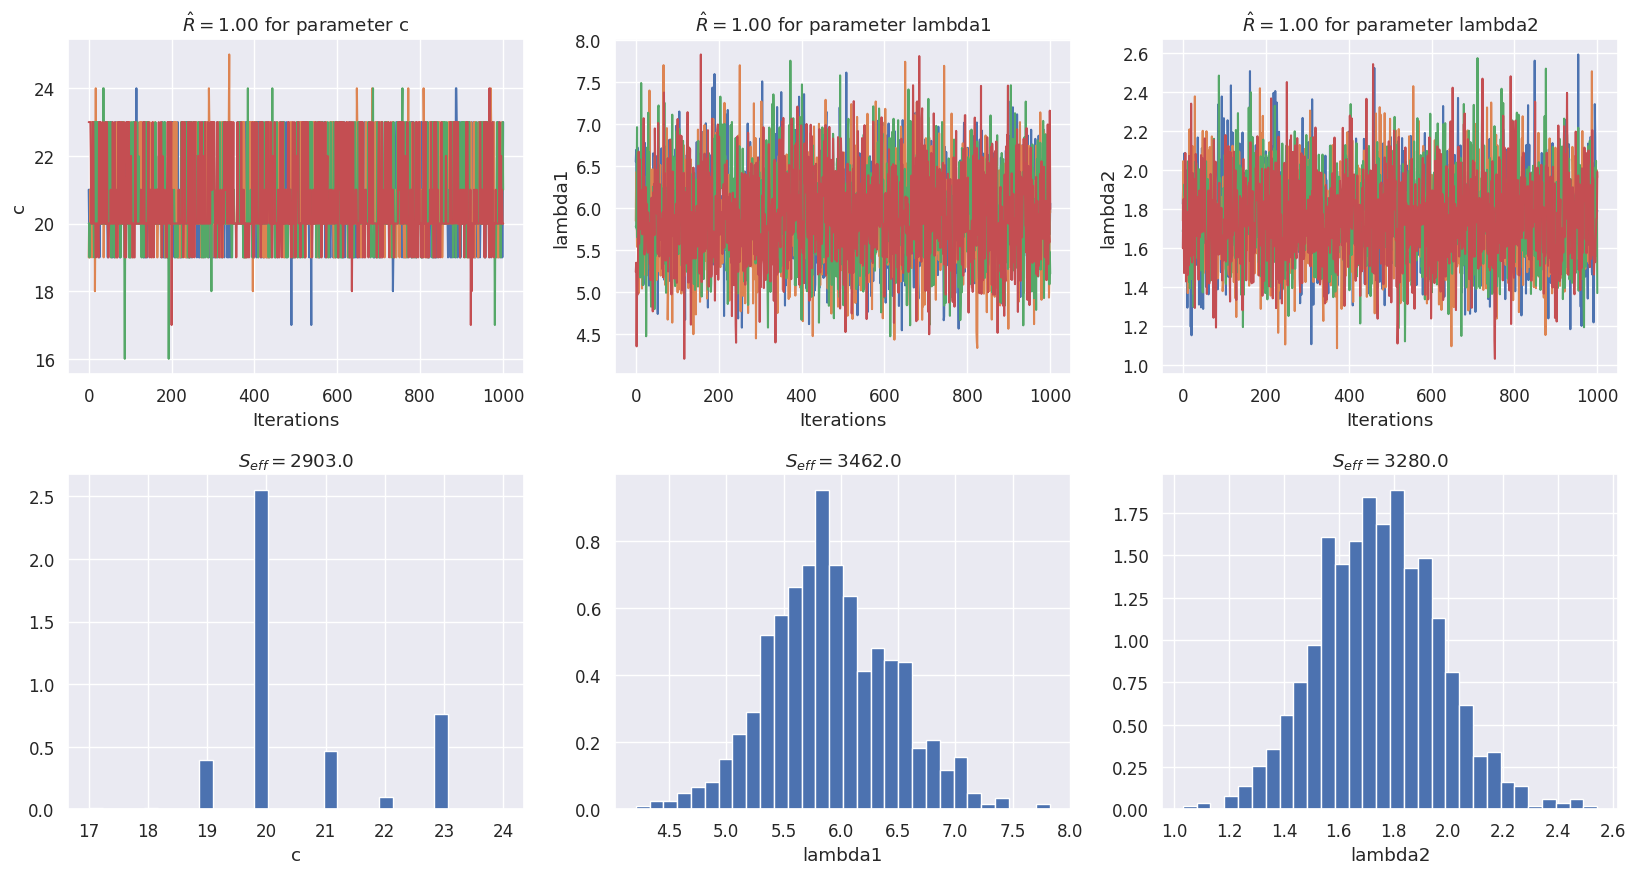

In [9]:
def plot_diagnostics(posterior_samples, parameter_names):

    # get dimensions
    num_chains, num_samples, num_params = posterior_samples.shape
    
    # calculate diagnostics
    Rhats = compute_Rhat(posterior_samples)
    Seff = compute_effective_sample_size(posterior_samples)
    
    # prep plot
    fig, axes = plt.subplots(2, num_params, figsize=(20, 10))
    for idx_param in range(num_params):
        for idx_chain in range(num_chains):

            # plot trace for each chain
            axes[0, idx_param].plot(posterior_samples[idx_chain, :, idx_param])

        axes[0, idx_param].set(title=f'$\\hat{{R}} = {Rhats[idx_param]:3.2f}$ for parameter {parameter_names[idx_param]}', ylabel=parameter_names[idx_param])        
        axes[0, idx_param].set_xlabel('Iterations')

        # plot histogram
        axes[1, idx_param].hist(posterior_samples[idx_chain, :, idx_param].flatten(), 30, density=True)
        axes[1, idx_param].set(title=f'$S_{{eff}}= {Seff[idx_param]:3.1f}$', xlabel=parameter_names[idx_param])

    fig.subplots_adjust(hspace=0.3)
    
# combine samples into an array of shape (num_chains, num_samples, num_params)
posterior_samples = jnp.stack((c_samples, l1_samples, l2_samples), 2)

# make list of parameter names for plotting
parameter_names = ['c', 'lambda1', 'lambda2']

# plot
plot_diagnostics(posterior_samples, parameter_names)

**End of solution**


**Task 3.4**: By visual inspection of the trace plots, do the chains for all parameters appear to have converged/mixed? Does the $\hat{R}$-diagnostic agree? Experiment with the number of warm up samples? How fast does the Gibbs sampler converge for this model? [**Discussion question**]



## Part 4:  Visualizing the posterior distributions for the change point detection model

Next, we will visualize the posterior distribution for $\lambda_1, \lambda_2,$ and $c$. First, we will define the Poisson rate $\lambda(\text{t})$ as a function of time $t$ as follows

$$\begin{align*}
\lambda(\text{t}) = \begin{cases} \lambda_1 \quad \text{if} \quad t \leq t_c\\
                           \lambda_2 \quad \text{if} \quad t > t_c,
                        \end{cases}
\end{align*}$$

where $t_c$ denotes the year for the $c$'th observation.

**Task 4.1**: Plot the posterior mean and a 95\% credibility interval of $\lambda(t)$, i.e. $p(\lambda(t)|\mathcal{D})$, superimposed on the data below.

*Hints*: *Merge the chains and then for each posterior sample of $\lambda_1, \lambda_2, c$, compute $\lambda(t)$ for the interval fra year 1851 to 1964. Next, you can compute the mean and interval for each time point and then plot it. You can use the function `plot_summary` for plotting the mean and intervals, or you can implement it on your own.*

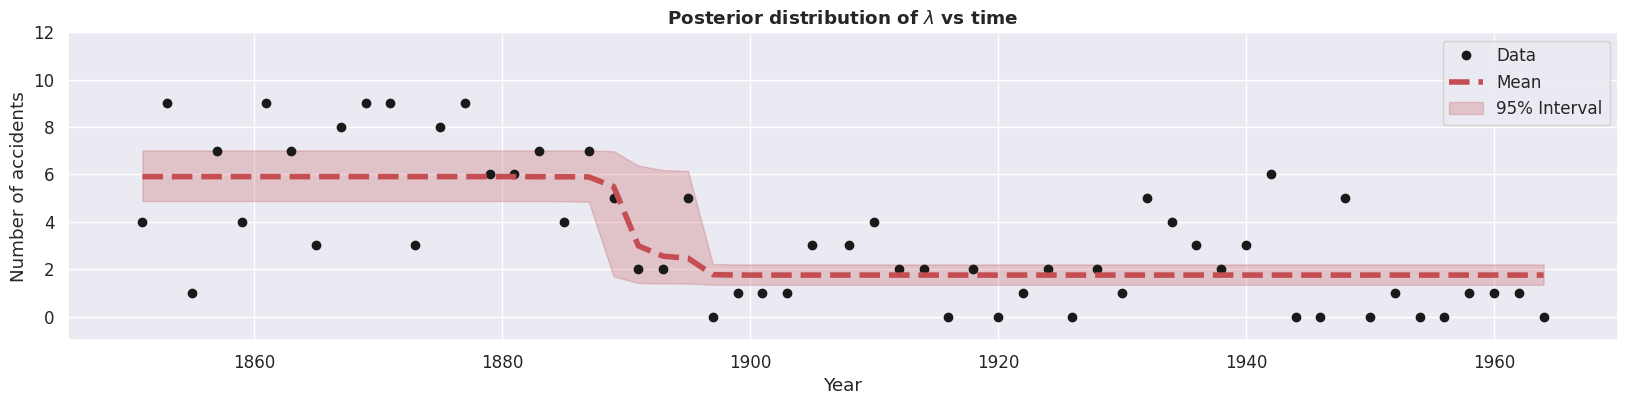

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
plot_data(ax)

##############################################
# Your solution goes here
##############################################

# merge chains and count total number of samples
posterior_samples_merged = posterior_samples.reshape((-1, 3))
num_total_samples = len(posterior_samples_merged)

# prepare to store samples of lambda(t)
lambda_t_samples = []

# for each triplet  of samples
for (c, lambda1, lambda2) in posterior_samples_merged:
    c = int(c)    
    lambda_t = jnp.zeros((N))
    lambda_t = lambda_t.at[:c].set(lambda1)
    lambda_t = lambda_t.at[c:].set(lambda2)
    lambda_t_samples.append(lambda_t)

lambda_t_samples = jnp.stack(lambda_t_samples)

# visualize
plot_summary(ax, year, lambda_t_samples, num_samples=0, title='Posterior distribution of $\\lambda$ vs time')

##############################################
# End of solution
##############################################


Similarly, we can define the number of accidents $x(t)$ as a function of time $t$ as follows

$$\begin{align*}
x(t)|\lambda_1, \lambda_2, c \sim \text{Poisson}(\lambda(t)),
\end{align*}$$


where $\lambda(t)$ is as defined above.

**Task 4.2**: Plot the posterior (predictive) mean and a 95\% credibility interval for $p(x(t)|\mathcal{D})$ superimposed on the data below.

*Hint: Use ancestral sampling*



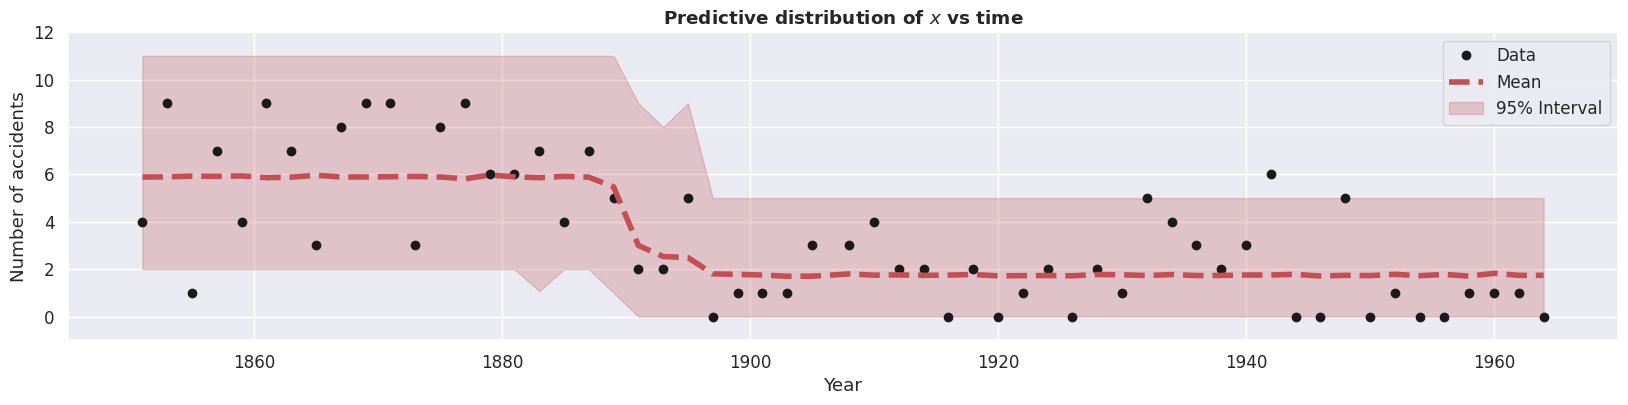

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
plot_data(ax)

##############################################
# Your solution goes here
##############################################

x_t_samples = random.poisson(key, lambda_t_samples)
    
# visualize
plot_summary(ax, year, x_t_samples, num_samples=0, title='Predictive distribution of $x$ vs time')

##############################################
# End of solution
##############################################

**Task 4.3**: Compute the posterior mean and standard deviation of the for all posterior parameters, i.e. $\lambda_1$, $\lambda_2$, and $c$ (using all samples for all chains).

**Solution**

In [12]:
for idx_param in range(3):

    # compute mean and std
    mean = jnp.mean(posterior_samples_merged[:, idx_param])
    std = jnp.std(posterior_samples_merged[:, idx_param])

    # print
    print(f'{parameter_names[idx_param]}\t\tmean={mean:3.2f}\tstd={std:3.2f}')

c		mean=20.59	std=1.27
lambda1		mean=5.91	std=0.54
lambda2		mean=1.75	std=0.22


**End of solution**

**Task 4.4**: Compute the MCSE for the posterior mean for each parameter. Given these estimates, how many significant digits would it make sense to report for the estimate of the posterior mean?

**Solution**

In [13]:
# compute mean and MCSE for each parameter
post_std = jnp.std(posterior_samples_merged, axis=0)
S_eff = compute_effective_sample_size(posterior_samples)
MCSE =  post_std/jnp.sqrt(S_eff)

for idx_param in range(3):


    print(f'{parameter_names[idx_param]}\t\tmean = {jnp.mean(posterior_samples_merged[:, idx_param]):3.2f}, \t MCSE = {MCSE[idx_param]:4.3f}')


c		mean = 20.59, 	 MCSE = 0.024
lambda1		mean = 5.91, 	 MCSE = 0.009
lambda2		mean = 1.75, 	 MCSE = 0.004


Hence, report the posterior means with more than 3-4 significant digits do not much since the MCSE are on the order of $10^{-2}$ and $10^{-3}$, respectively.

**End of solution**

**Task 4.5**: Recall, $t_n$ is the year of $n$'th observation and $t_c$ is the year of the change point. Plot a histogram of the posterior for $t_c$ and compute posterior mean of $t_c$, i.e. the posterior mean of the year for the change point.

**Solution**

Posterior mean of year for change point: 1892.19


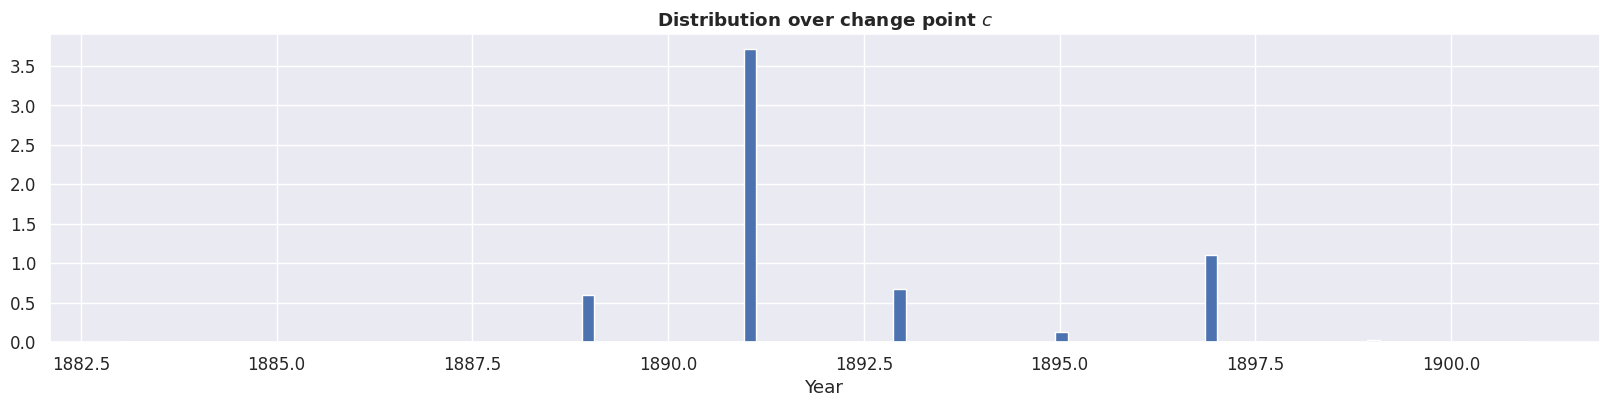

In [14]:
c_samples = posterior_samples_merged[:, 0].astype('int')
changepoint_samples = year[c_samples]

fig, ax = plt.subplots(1, 1, figsize=(20, 4))
ax.hist(changepoint_samples, int(year[-1]-year[0]), density=True);
ax.set_xlabel('Year');
ax.set_title('Distribution over change point $c$', fontweight='bold')

print(f'Posterior mean of year for change point: {jnp.mean(changepoint_samples):3.2f}')


**End of solution**

**Task 4.6**: Compute the posterior mean of $x(t)$ for $t \in \left\lbrace 1880,1895, 1920 \right\rbrace$

**Solution**

In [15]:
t_vals = [1880, 1895, 1920]

# key
key = random.PRNGKey(1)

for i, t in enumerate(t_vals):
    key, subkey = random.split(key)

    lambda_samples = jnp.array([lambda1 if t <= year[int(c)] else lambda2 for c, lambda1, lambda2 in posterior_samples_merged])
    x_samples = random.poisson(subkey, lambda_samples)
    print(f'The posterior mean for x({t}) and std. dev are {jnp.mean(x_samples):3.2f}')


The posterior mean for x(1880) and std. dev are 5.91
The posterior mean for x(1895) and std. dev are 2.58
The posterior mean for x(1920) and std. dev are 1.75


**End of solution**

**Task 4.7**: Compute the posterior probability $P(c < 20|\mathcal{D})$, i.e  that the change point $c$ is strictly smaller than $20$.

**Solution**

In [17]:
prob = jnp.mean(posterior_samples_merged[:, 0] < 20)
print('P(c < 20|x):\t\t%3.2f' % prob)

P(c < 20|x):		0.10


**End of solution**

**Task 4.8**: Compute the posterior probability for $\lambda_1$ being more than 3 times larger than $\lambda_2$.

**Solution**


In [18]:
lambda1_samples = posterior_samples_merged[:, 1]
lambda2_samples = posterior_samples_merged[:, 2]

I = lambda1_samples > 3*lambda2_samples
print(f'Posterior probability of lambda1 > 3*lambda2: {jnp.mean(I):4.3f}')

Posterior probability of lambda1 > 3*lambda2: 0.784


**End of solution**